<a href="https://colab.research.google.com/github/profshai/time-series/blob/main/sarimax_champagne_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecast future sales using:
* ARIMA - Autoregressive Integrated Moving Averages
* SARIMAX - Seasonal ARIMA

NOTE: The data must be stationary

The dataset comes from Kaggle and contains Perris Feres monthly champagne sales from January 1964 to September 1972.

We want to forecast future sales using ARIMA and SARIMAX

### Import libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Import dataset

In [9]:
df = pd.read_csv("champagnesales.csv")

In [10]:
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [11]:
df.columns = ['Month', 'Sales']

In [12]:
# Last two rows have missing data so we drop them
df.drop([105,106], axis=0, inplace=True)

In [13]:
df.tail()

,Month,Sales
100,1972-05,4618.0
101,1972-06,5312.0
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0


In [14]:
# Convert Month into Datetime
df['Month'] = pd.to_datetime(df['Month'])
df.head()

,Month,Sales
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0


In [15]:
df.set_index('Month', inplace=True)
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [16]:
df.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


### Visualize data

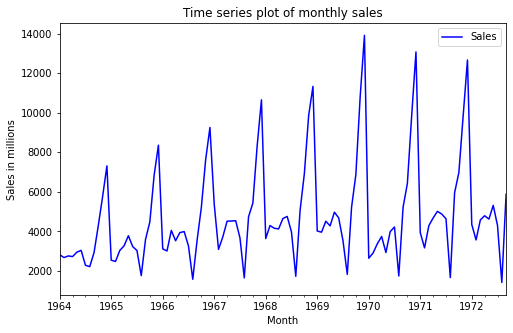

In [17]:
df.plot(figsize=(8, 5), color= 'blue')
plt.legend()
plt.ylabel('Sales in millions')
plt.title('Time series plot of monthly sales')
plt.show()

In [19]:
### Test For Stationarity
from statsmodels.tsa.stattools import adfuller

In [20]:
test_result = adfuller(df['Sales'])

In [21]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result = adfuller(sales)
    labels = ['ADF Test Statistic','p-value','Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("There is strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("There is weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [22]:
adfuller_test(df['Sales'])

ADF Test Statistic : -1.8335930563276226
p-value : 0.3639157716602452
Lags Used : 11
Number of Observations Used : 93
There is weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


### Differencing
* We want to make it stationary. We shift data by 12 positions representing 12 months since there is yearly seasonality.

In [23]:
df['Sales'].shift(12)

Month
1964-01-01       NaN
1964-02-01       NaN
1964-03-01       NaN
1964-04-01       NaN
1964-05-01       NaN
               ...  
1972-05-01    5010.0
1972-06-01    4874.0
1972-07-01    4633.0
1972-08-01    1659.0
1972-09-01    5951.0
Name: Sales, Length: 105, dtype: float64

In [24]:
df['Seasonal First Difference'] = df['Sales'] - df['Sales'].shift(12)
df.head()

,Sales,Seasonal First Difference
Month,,
1964-01-01,2815.0,NaN
1964-02-01,2672.0,NaN
1964-03-01,2755.0,NaN
1964-04-01,2721.0,NaN
1964-05-01,2946.0,NaN


In [25]:
# Let's do the test again
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -7.626619157213164
p-value : 2.060579696813685e-11
Lags Used : 0
Number of Observations Used : 92
There is strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


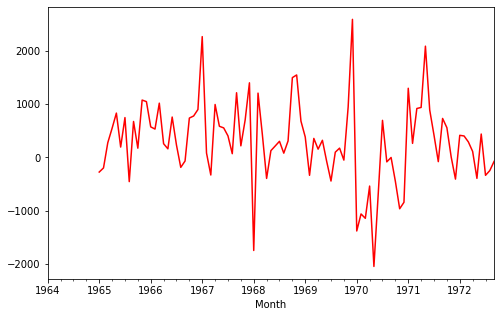

In [26]:
# Plot data
df['Seasonal First Difference'].plot(figsize=(8, 5), color= 'red')
plt.show()

### Auto Regressive model

In [27]:
from pandas.plotting import autocorrelation_plot

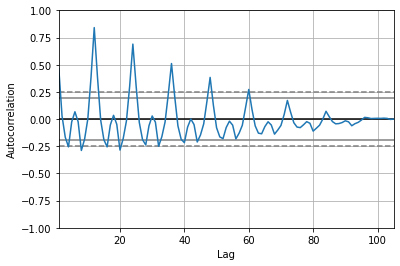

In [28]:
autocorrelation_plot(df['Sales'])
plt.show()

Now that we have removed the stationarity from our time series, we can make the ACF(Auto-correlation function) and PACF(Partial Auto-correlation function) plots which will help us decide the parameters of our Arima model.

1. Identification of an AR model is often best done with the PACF.

2. Identification of an MA model is often best done with the ACF rather than the PACF.

- p represents AR model lags 
- d is the differencing 
- q is the MA lags

In [29]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

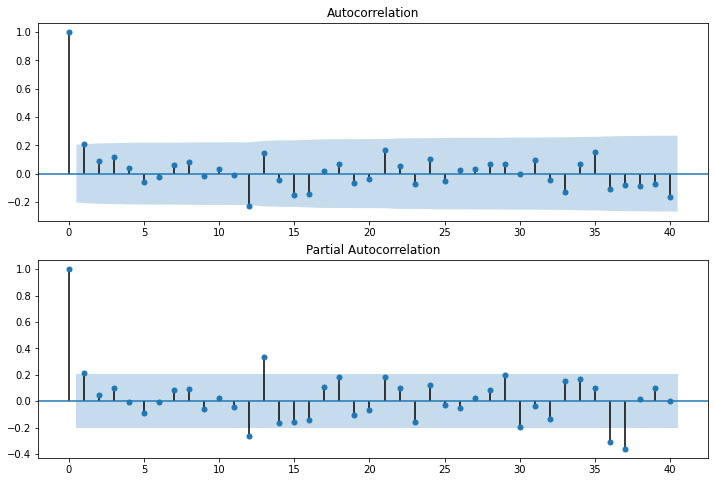

In [31]:
# First 12 observations are null

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

We will now build our ARIMA model. First we import the required class.

### ARIMA

... for non-seasonal data

In [32]:
from statsmodels.tsa.arima_model import ARIMA

In [33]:
#p=1, d=1, q=1
model=ARIMA(df['Sales'],order=(1,1,1))
model_fit=model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [34]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  104
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -951.126
Method:                       css-mle   S.D. of innovations           2227.262
Date:                Thu, 05 Aug 2021   AIC                           1910.251
Time:                        20:46:23   BIC                           1920.829
Sample:                    02-01-1964   HQIC                          1914.536
                         - 09-01-1972                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            22.7837     12.405      1.837      0.069      -1.530      47.097
ar.L1.D.Sales     0.4343      0.089      4.866      0.000       0.259       0.609
ma.L1.D.Sales    -1.0000      0.026    -38.503      0.000      -1.051      -0.949
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3023           +0.0000j            2.3023            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

### Forecasting with ARIMA model

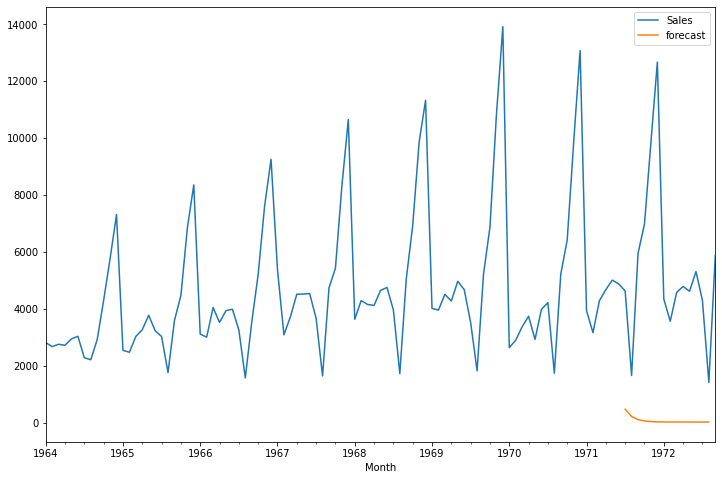

In [35]:
df['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

### SARIMAX

... for seasonal data

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [38]:
# Shift = 12

model=SARIMAX(df['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


### Forecasting with SARIMAX model

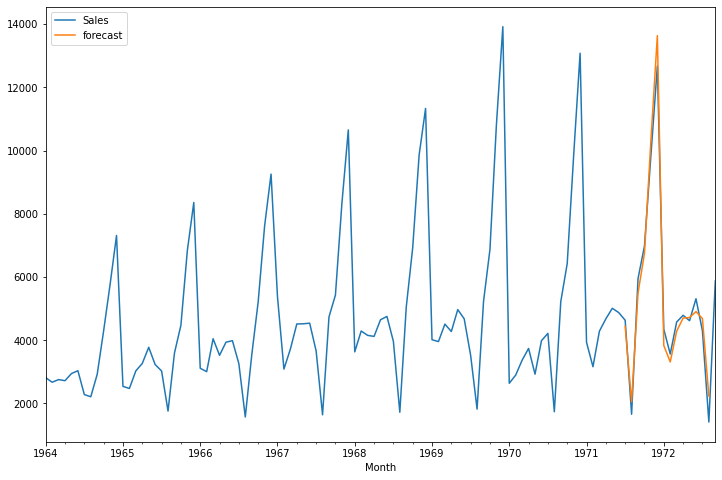

In [39]:
df['forecast']=results.predict(start=90,end=103,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

### Forecasting future sales with SARIMAX model

In [40]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [41]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [42]:
future_datest_df.tail()

,Sales,Seasonal First Difference,forecast
1974-04-01,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN


In [43]:
future_df=pd.concat([df,future_datest_df])

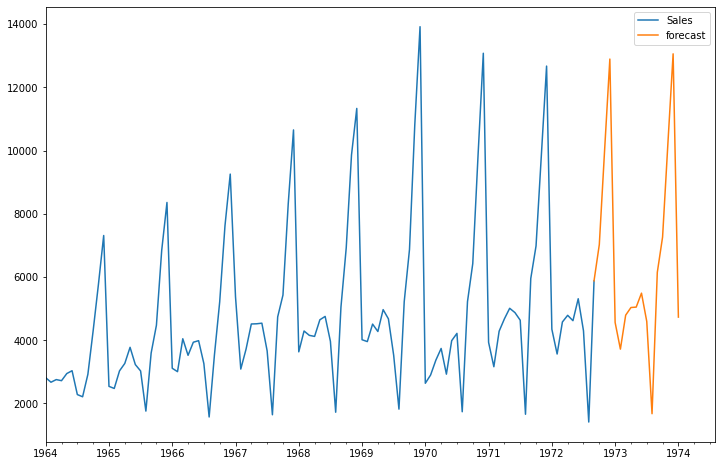

In [45]:
future_df['forecast'] = results.predict(start = 104, end = 120, dynamic= True)  
future_df[['Sales', 'forecast']].plot(figsize=(12, 8))

### End of Notebook!